Cell below loads all libraries used within this project.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import gzip
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve

This method was used from within the utils folder of the dataset to load different datasets and images withing fashion-MNIST dataset.

In [ ]:
def load_mnist(path, kind='train'):
    
    ''' from https://github.com/zalandoresearch/fashion-mnist'''

    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Principle components analysis or PCA, is a technique for reducing the dimensionality of datasets. The aim is to increase a databases interpretability while minimizing information loss. This is achieved by creating new uncorrelated variables that successively maximize variance. in the cell below, the dataset is loaded and then standardized by dividing them by 225 since they are all pixel values. Furthermore, their mean is calculated, and the data is normalized to make the PCA appliance easier. The first 25 images are shown with matching labels in the block below. Method 'conv_2d' splits the 1d input of 784 pixels into 2d with the shape (28,28) to make the plotting possible.

There are 10 unique classes within this dataset which are : 0-t-shirt/top', 1-'Trouser', 2-'Pullover', 3-'Dress', 4-'Coat', 5-'Sandal', 6-'Shirt', 7-'Sneaker', 8-'bag', 9-'ankle boot.

In [ ]:
fashion_X_train, train_y_labels = load_mnist('C:/Uni/Year3/MLCW//fashion-mnist/data/fashion', kind='train')
fashion_X_test, test_y_labels = load_mnist('C:/Uni/Year3/MLCW/fashion-mnist/data/fashion', kind='t10k')

class_names = ['t-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'bag', 'ankle boot']

x_train_orig = fashion_X_train
x_test_orig = fashion_X_test
#standardization: devided by 255
x_train_standard = fashion_X_train/255
x_test_standard = fashion_X_test/255

#normalizing by finding mean and calculating distance from mean
train_mean = np.mean(x_train_standard)
test_mean = np.mean(x_test_standard)

train_normal = x_train_standard - train_mean
test_normal = x_test_standard - test_mean

def conv_2d(matrix):
    for x in matrix:
        matrix = np.reshape(matrix, (28,28))
    return matrix

plt.figure(figsize=(7,7))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    train_images = conv_2d(fashion_X_train[i])
    plt.imshow(train_images, cmap=plt.cm.binary)
    plt.xlabel(class_names[train_y_labels[i]])
plt.show()

The dimensionality of the data is 784, consistant of 28x28 pixels. PCA is performed here to understand whether this reduction significantly impacts our information retention or not. a good reduction will aim to keep most of the information while discarding as many dimensions as possible. Here, we learn some quantities about these data namely different components and cumulative variance of the components. These represent the principal components of the data. in the code cell below evector of >=0.8 is taken from the cumulative variance as we want to retain 80+% of our datapoints as it is the ideal number. This is done to gain an understanding of what would be an ideal reduction.

In [ ]:
pca = PCA()
fit_all = pca.fit_transform(train_normal)

explained_var = pca.explained_variance_ratio_
cumulative_ratio = np.cumsum(explained_var)
less_eq_80 = np.where(cumulative_ratio >= 0.8)[0][0] #evector with cumulative variance ratio of >=0.8

print("ideal pc retention = "+str(less_eq_80+1))
print(f"first 5 PCs: {pca.explained_variance_[:10]}")

PCA was applied to all data and the pca object of the first 10 principles were returned. With this analysis we intend to keep higher variances. The output tells us that the cumalitive variance decreases rapidly between first 3 components. Furthermore, to understand how many dimension would be ideal to retain, Cumulative Variance Ratio per Principal Component is plotted. This better visualizes the pca of whole data. It can be observed that the first "51" principle components can explain 80% of the variance in this dataset. so reducing the datasets to 51 dimensions is ideal.

in the cell below we reduce the dimensionality of our data to 2 components. the data is then visualized as we plot the first component against the second component. Cumulative variance of the two components are also printed.

In [ ]:
pca_2 = PCA(n_components=2)
fit_2d = pca_2.fit_transform(train_normal)
explained_var = pca_2.explained_variance_#variance
cumalitive_var = np.cumsum(explained_var)#cumulative var
print(explained_var, 'pcs variance')
print(cumalitive_var, ' cumulitative variance')


plt.figure(figsize=(10,10))
scatter = plt.scatter(fit_2d.T[0], fit_2d.T[1], c=train_y_labels)
clb = plt.colorbar(scatter) #colour coding
clb.ax.set_title('Class') #colour coding
plt.xlabel("1st principle comp")
plt.ylabel("2nd principle comp")
plt.title('2D pca')

The first principle component is "19.80980567" and the second principle component is "31.92201614" clearly showing the gap between the two components are high. This tells us that reducing to 2d from 780+ dimensions is not a good idea since all the classes keep clustering into each other and there is no clear separation between the classes and most of the datapoint are lost and we are underfitting our data. We can furthur prove that this reduction is not fitting with plotting our images with this reduction

In [ ]:
fig, axes = plt.subplots(2,2, figsize = (10,5), sharex=True, sharey = True, constrained_layout = True )

# First 2 principal components
p_2d = [pca.components_[i].reshape(28,28) for i in range(0,2)]

for pc in range(0,2):
    axes[0,pc].imshow(p_2d[0], aspect='auto', cmap = "gray_r")
    axes[1,pc].imshow(p_2d[pc], aspect='auto', cmap = "gray_r")
plt.show()

It is demonstrated that the images come out extremly blurry and do not really represeant all of the shapes we will see within our dataset. Moreover, these images show that most variance in the data is found between the pixel values of a dark shirt and the pixel values of a white shoe.

in the code block below a simple K-means clustering is being employed. Each data is being assigned a cluster and cluster centres are calculated and marked inside each cluster. This is an unsupervised task with the task to separate points inside a dataset into different clusters such that elements within each cluster are similar. GMM is an example of soft clustering while K-mean is an example of hard clustering

In [ ]:
kmeans = KMeans(n_clusters=10)
label = kmeans.fit_predict(fit_2d)
centroid = kmeans.cluster_centers_
unique = np.unique(label)

plt.figure(figsize=(10,10))
for i in unique:
    plt.scatter(fit_2d[label == i , 0] , fit_2d[label == i , 1] , label = i)
    plt.scatter(centroid[:,0], centroid[:,1], s = 80, color = 'b')
plt.show()

GMM

Gaussian mixture model is a probabilistic model that is assembled by different gaussian distributions with each having their own mean and standard deviation. in GMM, we do a weighted average of all of them to mix them into one gaussian distribution hence the name mixture model. Since GMM is a probabilistic model, it is possible to find probabilistic cluster assignments. Using "fit_predict()" to find clusters for a number of our data points, 300 to be exact. Predictions are then scattered into a plot for better visualization. 
Furthermore, the cluster centroids are represented by a grey X marker within the scatters.

In [ ]:
colours = ['red', 'green', 'purple', 'yellow', 'blue', 'cyan', 'black', 'grey', 'orange', 'brown']

gmm = GaussianMixture(n_components=10, random_state=0 ,init_params='kmeans')
x = fit_2d
mea = gmm.fit(x).means_
means = np.mean(mea)
pred_labels = gmm.fit_predict(x)
score = gmm.score(x)
std = np.std(x)
print('std', std)
print('mean', means)
print('score', score)

plt.figure(figsize=(10,10))
pred = plt.scatter(x[:, 0], x[:, 1], c=pred_labels, cmap='viridis', s=20) #predictions
clb = plt.colorbar(pred) #colour coding
clb.ax.set_title('Class labels') #colour coding
plt.show()

centers = np.empty(shape=(gmm.n_components, x.shape[1]))
mean_centre = gmm.means_
cov_centre = gmm.covariances_
plt.figure(figsize=(10,10))
for i in range(gmm.n_components):
    density = multivariate_normal(mean_centre[i], cov_centre[i]).logpdf(x)
    centers[i, :] = x[np.argmax(density)]
plt.scatter(centers[:, 0], centers[:, 1], s=500, c='grey', marker='X')
print(centers)

The cluster centres are:

[[ 3.8964778   1.3946751 ], [-3.2280289  -2.44768891], [ 2.2198116  -3.81102286], [-3.79174098  3.77144966], [-0.22498571 -5.51308641], [-6.25434046  0.76931686], [ 0.40075786  5.15356899]

[-0.13584998  0.023941  ], [ 5.672128   -2.46995549], [ 6.96354057  2.74467447]].

z-score for this model is "-5.047949428065528" with some minor overlapping happening between the classes. This score reveals that these datapoints are about 5 standard deviations away from the mean. Data's standard deviation is "3.995089742715105" and the mean is "0.2550780733852641". Since there is a large gap between the mean and standard deviation, it suggests that our data are scattered and not close to each other. It is worth mentioning that the random states in set to zero hence making it possible that the expectation maximization step(EM), has missed globally optimal solutions.

Below we manipulate the data furthure by changing the number of random states present within our model to 42 for understanding whether this will have an impact or not. This variable, changes the test, train split, furthure splliting our data points into test and train subsets.

In [ ]:
gmm = GaussianMixture(n_components=10, random_state=42 ,init_params='kmeans')
x_42 = fit_2d
mea_42 = gmm.fit(x_42).means_
means_42 = np.mean(mea_42)
pred_labels_42 = gmm.fit_predict(x)
score_42 = gmm.score(x_42)
std_42 = np.std(x)
print('std', std_42)
print('mean', means_42)
print('score', score_42)

plt.figure(figsize=(10,10))
pred = plt.scatter(x[:, 0], x[:, 1], c=pred_labels_42, cmap='viridis', s=20) #predictions
clb = plt.colorbar(pred) #colour coding
clb.ax.set_title('Class labels') #colour coding
plt.show()

centers = np.empty(shape=(gmm.n_components, x.shape[1]))
mean_centre = gmm.means_
cov_centre = gmm.covariances_
plt.figure(figsize=(10,10))
for i in range(gmm.n_components):
    density = multivariate_normal(mean_centre[i], cov_centre[i]).logpdf(x)
    centers[i, :] = x[np.argmax(density)]
plt.scatter(centers[:, 0], centers[:, 1], s=500, marker='X')
print(centers)

By changing the random state, the standard deviation of data remains the same while the mean changes. The change in the mean impacts our Z score as well but since the change in our mean is minimal, this does not change anything. The cluster centres do change which is the expected observation however, the genral vicinity of them do not different from when random_state was set to 0.

The cluster centroid are consistant with the K-means clustering and previuse gmm clusters. It remains to be seen wheteher it is consitant when all dimensions are present. As shown by 2d reduction in PCA, majority of the data is lost so it is expected for these clusters to not be accurate and not a good representation of different classes.

Cell below calculates how accurate our predictions are compared to the true values within the dataset. "accuracy()" function takes 2 inputs, compares them and returns a percentage on how equivilant they are. Furthermore, we see how many different classes our predictions included that were true.

In [ ]:
def accuracy(predictions, actual):
    x = 0
    for i in range(len(predictions)):
        if predictions[i] == actual[i]:
            x+=1
    return print('accuracy percentage is:', (((x)/len(predictions))*100))

accuracy(pred_labels, train_y_labels)

correct_pred = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
for i in range(3000):
        if pred_labels[i] == train_y_labels[i]:
                    val = train_y_labels[i]
                    correct_pred[val]+=1

print(correct_pred)

Acurracy of the prediction are very low as predicted by our PCA analysis. Using all of the training data (60000), the acuraccy is only "7.948333333333333" percent or almost 8%. Moreover from the output, we observe that classes 3, 4, 8 and 10 were not at all predicted correctly while class 6 had the most correct predictions by a landscape although the predcition rate there was low as well. Recall from our PCA analysis the class associated with "shirts" were the most visible when we reduced our dimensions to 2d. So it should come as no surprise when class 6 which is shirts were predicted correctly the most. White shoes from snekaers class was the other closest visible however it was not predicted all but once within our prediction

Overall the soft clustering on a 2d reduction does not output adequate predictions as with this reduction, majority of our information is lost. As mentioned before, reducing to 24 dimensions will ensure about 80% retention of information which is recommanded.

We move on to ANN or Artificial Neural Networks.

Firstly the logistic regression is fitted to our data which is a linear model for classification. The probabilities describing the possible outcomes of a classification are modeled using a logistic (sigmoid) function. We are trying to find the prediction accuracy of our train and test splits with this which are 87% and 84% respectively over 100 iterations.

Training Neural networks is acomplished by learning the weights and biases in the hidden and output layers such that the network, outputs the correct optimal labels. Network's performance is defined by a loss function for which here a logistic regression is employed. The cost function is the sum of all the erroror logified, applied to all the training datapoints.

In [ ]:
x_train_nn = x_train_standard[:3000]
x_test_nn = x_test_standard[:3000]

test_y_nn = test_y_labels[:3000]
train_y_nn = train_y_labels[:3000]


logreg = LogisticRegression(max_iter=100)
logreg.fit(x_train_standard, train_y_labels)
print('Testing accuracy: ', (logreg.score(x_test_nn, test_y_nn)))
print('Training accuracy: ', (logreg.score(x_train_nn, train_y_nn)))

In the cell above a logistic regression was fit to our training data and the accuracy of both testing and training data was measured. it is a linear model of classification that is modeled after the sigmoid function. On 3000 datapoints over 100 iterations, this model's accuracy against training data was 86.2% while it was 84.7% on testing data. The gap between the scores is not high suggesting that our model is likely not overfitting. It is worth mentioning that running this on all datapoints for over 2000 iteration failed to converge and yielded almost 87% accuracy on both testing and training datasets however that is very time consuming to compute and almost fried my laptop.

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(64),
                    activation='relu',
                    solver='sgd',
                    alpha=0,
                    learning_rate_init=1e-3,
                    max_iter=1800,
                    n_iter_no_change=25,
                    random_state=1)

train = mlp.fit(x_train_nn, train_y_nn)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(train.loss_curve_, c='orange')
ax.set_title('orange-train, blue-test')
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Loss')

test = mlp.fit(x_test_nn, test_y_nn)

ax.plot(test.loss_curve_, c='blue')

in the code cell above, ANN was applied using the multiple layer classifier from sklearn python library. The loss curve for both test and training data was plotted and it was observed that they were both extremely similar. This was expected due to logistic regression's score for both training and testing data being so close to each other. This ANN model, does not seem to be overfitting as the loss for both datasets are low. Also, the model's loss curves, do not climb after the initial dip which is a sign that the model is not overfitting. Furthurmore, our data is large and was standardized before applying the classifier which reduces overfitting. We move on to plotting a confusion matrix to understand our model's accuracy, as well as figuring out accuracy of our datasets.

In [ ]:
print('Testing accuracy:', mlp.score(x_test_nn, test_y_nn))
print('training accuracy:', mlp.score(x_train_nn, train_y_nn))

plot_confusion_matrix(mlp, x_test_nn, test_y_nn)

Scores, or the accuracy mean, of the model against testing data is 82.7% while it is 98.2% against training data. Our network model performs well on both datasets however the gap between the two datasets seems to be a bit high than ideal suggesting a slight overfitting. Furthermore a confusion matrix was plotted to understand our model's performance. From this we can see that our model against testing data made the most mistake when attempting to distinguish between classes 0(t-shirts/top) and 6(shirt), 4(coats) and 2(pullover), 6(shirt) and 2(pullover) and so on. It can be understood keeping in mind the similiarities between these classes however the model did very well with over 83% accuracy across all of the data points. Similar story was told when plotting the confusion matrix against our training datasets however there were more errors in the same classes.

Our model's performance is dependant on our hyperparameters. Optimizing them will lead to better performance by our model and is a crucial part of machine learning. Ultimateley we want our Score to be as high as possible which means our model is nearer to perfect accuracy. Here we will use randomizedsearchCV to perform hyperparameters tuning, here we set the cross validation split to 3, each having 10 iterations for performance optimization. We will optimize initial learning rate and alphas. Alpha here refers to regularization term's strength which is devided by the sample size and added to the loss. This parameter controls the weighting of our regularization within cost funtion to better control overfitting. Initial learning rate "m" is another important parameter which is used in updating the weights by controling the step-size. For consistency we will keep every other Hyperparameter the same. Note that this takes a long time to carry out.

In [ ]:
learning_rates_init = np.logspace(-4, -2, 100)
alphas = np.logspace(-3, -0, 100)

hype_param = {'learning_rate_init':learning_rates_init, 'alpha':alphas}

clf = RandomizedSearchCV(mlp, hype_param, cv=3, n_iter=10, verbose=2, scoring='accuracy', )

clf.fit(x_train_nn, train_y_nn)
clf.best_params_

Initial learning rate of " 0.00031992671377973844" and alpha or regularisation of "0.006579332246575682" has been outputed. Below we apply a new neural network with these tweaked hyperparameters and see if the accuracy of our data changes. All other hyperparaneters stay unchanged. This NN, will have 64 layers and 1800 iteration over 3000 datasets just as the previous classifier.

In [ ]:
nn = MLPClassifier(hidden_layer_sizes=(64),
                    activation='relu',
                    solver='sgd',
                    alpha=0.006579332246575682,
                    learning_rate_init=0.00031992671377973844,
                    max_iter=1800,
                    n_iter_no_change=25,
                    random_state=1)

train = nn.fit(x_train_nn, train_y_nn)

print('Testing accuracy:', nn.score(x_test_nn, test_y_nn))
print('training accuracy', nn.score(x_train_nn, train_y_nn))

plot_confusion_matrix(nn, x_test_nn, test_y_nn)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(train.loss_curve_, c='orange')
ax.set_title('orange-test, blue-train')
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Loss')
test = nn.fit(x_test_nn, test_y_nn)
ax.plot(test.loss_curve_, c='blue')

The changes done on these hyperparameters does slightly improve our accuracy against testing data. Our accuracy is 83.1% with the new tuned hyperparameters which is an improvement of 0.4%. Similar to our earlier neural network. Our loss curve was plotting to check for overfitting. The results are fairly similar and there is no sign of significant overfitting.

For furthere changes, here a new neural network is model with more layers and a different solver. Previously, we have used 64 hidden layers and the 'sgd' solver. SGD or stochastic gradient descent, computes an approximation rather than the true value of gradiet in each step which leads to noisier gradient decebt. It is mostly used because of simplicity and how fast it runs since it is linear. Adams's solver, have faster run time and need lesser parameters for optimization. For hidden layers, increasing them can lead to higher accuracy however it can be very time consuming and expensive to run.

In [ ]:
Ann = MLPClassifier(hidden_layer_sizes=(100),
                    activation='relu',
                    solver='adam',
                    alpha=0.006579332246575682,
                    learning_rate_init=0.00031992671377973844,
                    max_iter=1800,
                    n_iter_no_change=25,
                    random_state=1)

train = Ann.fit(x_train_nn, train_y_nn)
print('test accuracy:', Ann.score(x_test_nn, test_y_nn))
print('train accuracy:', Ann.score(x_train_nn, train_y_nn))

plot_confusion_matrix(Ann, x_test_nn, test_y_nn)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(train.loss_curve_, c='orange')
ax.set_title('orange-test, blue-train')
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Loss')
test = Ann.fit(x_test_nn, test_y_nn)
ax.plot(test.loss_curve_, c='blue')

These two changes, have made our accuracy againts testing data go up to 83.2% which is 0.1% improvement. Against training data we finally achieve 100% accuracy with the adam solver and more hidden layers. Our loss curve here for both training and testing data set changes slightly as it has more bumps through the decending gradient. Our model might be overfitting slightly more compared to other curves however it is insignificant.

For furthure tuning, we employ a gridsearchCV for tuning. For a given model, in our case a neural network, Grid Search is a cross-validation technique used for finding optimal hyperparameters when these are in a given grid and predictions are made. Layers will be 100 as we dont want to risk overfitting, while activation methods tested, will be 'softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', and 'linear'. Activation method, is responsible for deciding whether a neuron will be activated and its input is important within the neuron network. The previously tuned parameter, initial learning rate and regularisation will stay the same.

In [ ]:
parameters = {'hidden_layer_sizes': [100],
 'activation': ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'], 
 'solver': ['adam', 'sgd'],
 'alpha': [0.00031992671377973844],
 'learning_rate_init': [0.00031992671377973844],
 'max_iter':[1800],
 'n_iter_no_change':[25],
 'random_state':[1]}
gr = GridSearchCV(estimator=Ann, param_grid=parameters)
gr_out = gr.fit(x_train_nn, train_y_nn)
# summarize results
print("Best: %f using %s" % (gr_out.best_score_, gr_out.best_params_))
params = gr_out.cv_results_['params']
for param in zip(params):
    print(gr_out.score(x_test_nn, test_y_nn), param)

During the grid search, there are no furthure improvements to our accuracy. The activation parameter did not improve our performance the adam solver was proven to be the best. 'ReLU' or rectified linear activation will remain our parameter. This activation method only outputs if input is positive and output zero if its negative which impacts our performance and makes it faster.

SVM
Support Vector Machines (SVM) are nonparametric model where the number of parameters are not fixed and increase appropriate to the size of our data. Function below is available from 'https://github.com/rasbt/mlxtend/blob/master/mlxtend/plotting/learning_curves.py' and is used for plotting a learning curve for our fitted SVM. This function plots misclassification errors (performance) against training set's size. The size of both our testing and training dataset will be 5000, the regularisation parameter "c" will be 1 (defult) (same as ANN classifier) and kernel used will be the default 'rbf'.

Leaning curves shows both validation and traning scores as the number of our samples increase. It is a tool for estimating whether we benefit from adding more training data and how much our SVM is effected by variance or bias error. Two different function are utilised for visualising the learning curve, one function shows errors (plot_learning_curves) while the other is plotted using the accuracy of the model (plt_learn_curve_acc), both against training size.

For validation curve, we can see from it whether our model is overfitting or underfitting. Scores for both training and testing datapoints are calculated and plotted against a range of regularisation factors "C". High training scores paired with low validation score, suggests the SVM is overfitting. For this, function (plt_valid_curve) is introduced taking in an estimator (SVM in this case) and training and target samples, to plot validation curve of regularisation against accuracy of the training samples.

In [ ]:
def plot_learning_curves(X_train, y_train, X_test, y_test, clf, train_marker="o", test_marker="^", scoring="misclassification error", suppress_plot=False, print_model=True, title_fontsize=12,
    style="default", legend_loc="best"):
    if scoring != "misclassification error":
        from sklearn import metrics
        scoring_func = {
            "accuracy": metrics.accuracy_score,
            "average_precision": metrics.average_precision_score,
            "f1": metrics.f1_score,
            "f1_micro": metrics.f1_score,
            "f1_macro": metrics.f1_score,
            "f1_weighted": metrics.f1_score,
            "f1_samples": metrics.f1_score,
            "log_loss": metrics.log_loss,
            "precision": metrics.precision_score,
            "recall": metrics.recall_score,
            "roc_auc": metrics.roc_auc_score,
            "adjusted_rand_score": metrics.adjusted_rand_score,
            "mean_absolute_error": metrics.mean_absolute_error,
            "mean_squared_error": metrics.mean_squared_error,
            "median_absolute_error": metrics.median_absolute_error,
            "r2": metrics.r2_score,
        }

        if scoring not in scoring_func.keys():
            raise AttributeError("scoring must be in", scoring_func.keys())

    else:

        def misclf_err(y_predict, y):
            return (y_predict != y).sum() / float(len(y))

        scoring_func = {"misclassification error": misclf_err}

    training_errors = []
    test_errors = []

    rng = [int(i) for i in np.linspace(0, X_train.shape[0], 11)][1:]
    for r in rng:
        model = clf.fit(X_train[:r], y_train[:r])

        y_train_predict = clf.predict(X_train[:r])
        y_test_predict = clf.predict(X_test)

        train_misclf = scoring_func[scoring](y_train[:r], y_train_predict)
        training_errors.append(train_misclf)

        test_misclf = scoring_func[scoring](y_test, y_test_predict)
        test_errors.append(test_misclf)

    if not suppress_plot:
        with plt.style.context(style):
            plt.plot(
                np.arange(10, 101, 10),
                training_errors,
                label="training set",
                marker=train_marker,
            )
            plt.plot(
                np.arange(10, 101, 10),
                test_errors,
                label="test set",
                marker=test_marker,
            )
            plt.xlabel("Training set size in percent")

    if not suppress_plot:
        with plt.style.context(style):
            plt.ylabel("Performance ({})".format(scoring))
            if print_model:
                plt.title(
                    "Learning Curves\n\n{}\n".format(model), fontsize=title_fontsize
                )
            plt.legend(loc=legend_loc, numpoints=1)
            plt.xlim([0, 110])
            max_y = max(max(test_errors), max(training_errors))
            min_y = min(min(test_errors), min(training_errors))
            plt.ylim([min_y - min_y * 0.15, max_y + max_y * 0.15])
    errors = (training_errors, test_errors)
    return errors


def plt_learn_curve_acc(svm, x, y):
    train_sizes, train_scores_svm, test_scores_svm = learning_curve(svm, x, y, scoring="accuracy")
    plt.plot(train_sizes, -test_scores_svm.mean(1), color="orange")
    plt.plot(train_sizes, -train_scores_svm.mean(1), color="blue")
    plt.xlabel("Train size")
    plt.ylabel("accuracy")
    plt.title("Learning curves")
    plt.legend(loc="best")
    return plt.show()

In [ ]:
from sklearn.model_selection import validation_curve
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py

def plt_valid_curve(svm, x_train_svm, train_y_svm):
    param_range = np.logspace(-6, -1, 5)
    train_scores, test_scores = validation_curve(
    svm,
    x_train_svm,
    train_y_svm,
    param_name="C",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with SVM")
    plt.xlabel("regularisation")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(
        param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
    )
    plt.fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
        color="darkorange",
        lw=lw,
    )
    plt.semilogx(
        param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
    )
    plt.fill_between(
        param_range,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )
    plt.legend(loc="best")
    return plt.show()

In [ ]:
x_train_svm = x_train_standard[:5000]
x_test_svm = x_test_standard[:5000]
train_y_svm = train_y_labels[:5000]
test_y_svm = test_y_labels[:5000]

svm = SVC(C=1, kernel='rbf')
svm.fit(x_train_svm, train_y_svm)
print('SVM classifier accuracy againts training:', svm.score(x_train_svm, train_y_svm))
print('SVM classifier accuracy against testing:', svm.score(x_test_svm, test_y_svm))

plt_valid_curve(svm, x_train_svm, train_y_svm)

In [ ]:
#learning curve against error
plot_learning_curves(x_train_svm, train_y_svm, x_test_svm, test_y_svm, svm)
plt.show()

#learning curve against accuracy
plt_learn_curve_acc(svm, x_train_svm, train_y_labels)

The SVM model's score against our testing dataset is 84.1% while it is 90.0% against training set.
From the plot ouputed, the SVM model could not benefit from additional training data as the gradient for testing rapidly decreases as we reach all 5000 training size. So the testset error is not likely to decrease furthure than 12%. As we reach maximum training size, the error gap between testing and training data is 6% which is a not too large, suggesting the model does well.

Furthermore, with small datapoints, the gap between training and test set's performance is high. This can be addressed by increasing the regularisation value and the number of training samples, in which here we increased the input size. As the number of data increases the error for both testing and training dataset decrease showing that our model is performing well. Moreover, the accuracy of the model increases as the number of data points increase, the lowest value with 500 datapoints is around 76% while the highest with 4000 datapoints is about 85%.

From the validation curve, it is observed that both training score and our cross-validation score are very similar. suggesting that our model is working fine and is not overfitting or underfitting. In general, for small sample data, training score for SVM is bigger than validation score. This can be addressed by adding more sample data. As the regularisation term increases with our sample size, the score for both training data and validation increase which means our model is performing well.

In the code cell below, we use a grid search to tune our hyperparameters and extract the best to carry forward. The regularisation term "C" will ave 100 values between 0-20, and different kernels tested are 'sigmoid', 'rbf' and 'linear' are fitted. This will be 300 different fits with 3 cross validations leaving us with 900 fits for 5000 datapoints. The kernel specifies the type of algorithm to be used. "Linear" is the most basic and the fastest type of kernel and works best when there are a lot of features present like in fashion dataset. For non-linear data, rbf or Gaussian radial basis function is preffered while sigmoid kernels are preffered for neural networks. Gamma or the kernel coefficent is left as defult value.

In [ ]:
param_grid = {'C': np.linspace(0,20,100), 'kernel': ['rbf', 'linear', 'sigmoid']} 
  
grid = GridSearchCV(svm, param_grid, verbose = 2, cv=3)

grid.fit(x_train_svm, train_y_svm)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)

In [ ]:
svm = SVC(C=0.20202020202020202, gamma=0.01, kernel='linear')
svm.fit(x_train_svm, train_y_svm)

print(svm.score(x_train_svm, train_y_svm))
print(svm.score(x_test_svm, test_y_svm))

From this search, our best regularisation factor is "0.20202020202020202" and "linear" as the best kernel. These hyperparameters improve our training accuracy to 95% from 90% (using rbf kernel, and c=1) while they become less accurate against testing data with 82.2% accuracy from 84.1% suggesting a very slight overfitting.

Below the kernel parameter and how sensitive SVM is to them is tested by plotting learning curve and printing their accuracy. The tuned regularisation parameter (0.20202020202020202) and gamma 0.01 for all kernel types will be utilised. Furtheremore, validation curve for each kernel type is plotted against different regularisation values for better analysis and visualisation.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


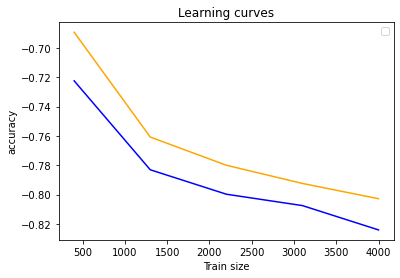

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


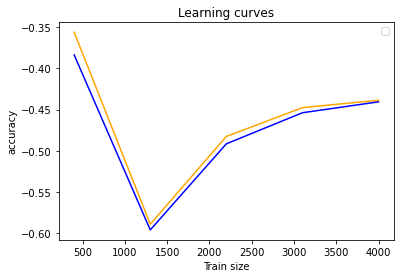

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


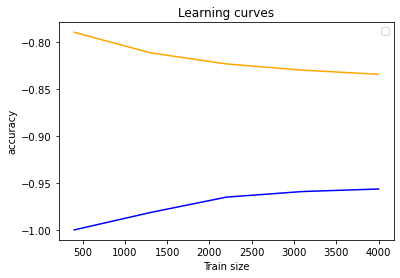

rbf accuracy 0.83
sigmoid accuracy 0.4302
linear accuracy 0.95


In [84]:
svm_linear = SVC(C=0.20202020202020202, gamma=0.01, kernel='linear')
svm_sigmoid = SVC(C=0.20202020202020202, gamma=0.01, kernel='sigmoid')
svm_rbf = SVC(C=0.20202020202020202, gamma=0.01, kernel='rbf')

svm_linear.fit(x_train_svm,train_y_svm)
svm_rbf.fit(x_train_svm,train_y_svm)
svm_sigmoid.fit(x_train_svm,train_y_svm)

plt_learn_curve_acc(svm_rbf, x_train_svm, train_y_svm)
plt.title("rbf")
plt.show()

plt_learn_curve_acc(svm_sigmoid, x_train_svm, train_y_svm)
plt.title("sigmoid")
plt.show()

plt_learn_curve_acc(svm_linear, x_train_svm, train_y_svm)
plt.title("linear")
plt.show()

print('rbf accuracy', svm_rbf.score(x_train_svm, train_y_svm))
print('sigmoid accuracy', svm_sigmoid.score(x_train_svm, train_y_svm))
print('linear accuracy', svm_linear.score(x_train_svm, train_y_svm))

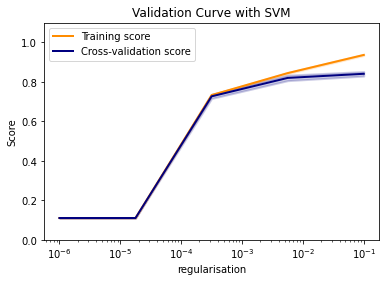

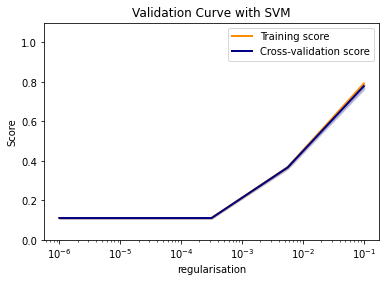

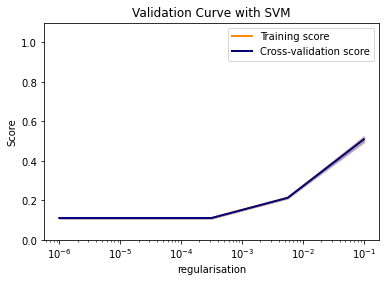

In [85]:
plt_valid_curve(svm_linear, x_train_svm, train_y_svm)
plt_valid_curve(svm_rbf, x_train_svm, train_y_svm)
plt_valid_curve(svm_sigmoid, x_train_svm, train_y_svm)

From the plots and final accuracy score, we can conclude that the best kernel is the linear kernel since it has a high accuracy score and better learning curve. The sigmoid kernel is the worst performing out of all since it has a very low score of 43% and loses accurcy as we increase our input samples. This kernel improves in accuracy with small sample size and maxes at 60% with about 1200 datapoints but beyond that rapidley declines in score. "rbf" kernel does well with both score (83%) and learning curve however it is outperformed by linear model by a margain of 12%.

The validation curve for both rbf and linear are the best suggesting that our model is performing very well with no sight of overfitting to our data. However, the sigmoid kernel starts to overfit significantly as the regularisation value gets bigger. This means that with furthure tuned value of C, sigmoid kernel might fit better. Before we used all positive values of C for tunining (ranging from 0-20) however the validation curve shows that this kernel can be optimised by having a regularisation factor between "10^-4 - 0". It is worth mentioning that accuracy of sigmoid kernel does not go higher than 80%, with a clear seperation between validation and training curve suggesting overfitting, which is still the third best kernel out of the tested three.

In conclusion, the best kernel is the "linear" kernel and for this kernel the regularisation factor "c" of "0.20202020202020202" gives us the best performance.